In [1]:
import os
import numpy as np
import torch
from PIL import Image
import transforms as T
import torch
torch.cuda.set_device(3)

In [2]:
class SegDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "Images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "labelsInstance"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "Images", self.imgs[idx])
        mask_path = os.path.join(self.root, "labelsInstance", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        mask = mask[:,:,0]
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]
        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [3]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [4]:

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
T.

In [10]:
from engine import train_one_epoch, evaluate
import utils


def main():
    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # our dataset has two classes only - background and person
    num_classes = 2
    # use our dataset and defined transformations
    dataset = SegDataset('dataset', get_transform(train=True))
    dataset_test = SegDataset('dataset', get_transform(train=False))

    # split the dataset in train and test set
    indices = torch.randperm(len(dataset)).tolist()
    dataset = torch.utils.data.Subset(dataset, indices[:-10])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-10:])

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=4,
        collate_fn=utils.collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=4,
        collate_fn=utils.collate_fn)

    # get the model using our helper function
    model = get_model_instance_segmentation(num_classes)

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

    # let's train it for 10 epochs
    num_epochs = 10

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)

    print("That's it!")
    aux=model
    aux=aux.cpu()
    traced_cell=torch.jit.script(aux)
    traced_cell.save("instanceSegmentation.pth")

In [11]:
main()

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [0]  [  0/144]  eta: 0:06:37  lr: 0.000040  loss: 6.2485 (6.2485)  loss_classifier: 1.0559 (1.0559)  loss_box_reg: 0.4057 (0.4057)  loss_mask: 4.5420 (4.5420)  loss_objectness: 0.1967 (0.1967)  loss_rpn_box_reg: 0.0483 (0.0483)  time: 2.7571  data: 2.4468  max mem: 2951
Epoch: [0]  [ 10/144]  eta: 0:01:36  lr: 0.000389  loss: 2.9133 (3.8783)  loss_classifier: 0.7155 (0.7229)  loss_box_reg: 0.4583 (0.5155)  loss_mask: 1.8304 (2.4332)  loss_objectness: 0.1470 (0.1616)  loss_rpn_box_reg: 0.0326 (0.0451)  time: 0.7195  data: 0.4187  max mem: 2951
Epoch: [0]  [ 20/144]  eta: 0:01:22  lr: 0.000739  loss: 1.7413 (2.6541)  loss_classifier: 0.3623 (0.5199)  loss_box_reg: 0.4034 (0.4315)  loss_mask: 1.1340 (1.5372)  loss_objectness: 0.0956 (0.1264)  loss_rpn_box_reg: 0.0326 (0.0391)  time: 0.5567  data: 0.2593  max mem: 2951
Epoch: [0]  [ 30/144]  eta: 0:01:18  lr: 0.001088  loss: 1.2324 (2.1978)  loss_classifier: 0.2944 (0.4622)  loss_box_reg: 0.3501 (0.4649)  loss_mask: 0.3523 (1.1357) 

Epoch: [1]  [ 50/144]  eta: 0:01:01  lr: 0.005000  loss: 0.4053 (0.4680)  loss_classifier: 0.1612 (0.1571)  loss_box_reg: 0.1557 (0.1714)  loss_mask: 0.1261 (0.1258)  loss_objectness: 0.0049 (0.0069)  loss_rpn_box_reg: 0.0056 (0.0067)  time: 0.5931  data: 0.2837  max mem: 2951
Epoch: [1]  [ 60/144]  eta: 0:00:50  lr: 0.005000  loss: 0.3951 (0.4550)  loss_classifier: 0.1302 (0.1537)  loss_box_reg: 0.1230 (0.1626)  loss_mask: 0.1149 (0.1255)  loss_objectness: 0.0049 (0.0068)  loss_rpn_box_reg: 0.0055 (0.0065)  time: 0.4891  data: 0.1832  max mem: 2951
Epoch: [1]  [ 70/144]  eta: 0:00:43  lr: 0.005000  loss: 0.3501 (0.4478)  loss_classifier: 0.1302 (0.1527)  loss_box_reg: 0.1143 (0.1595)  loss_mask: 0.1043 (0.1233)  loss_objectness: 0.0020 (0.0062)  loss_rpn_box_reg: 0.0040 (0.0061)  time: 0.4453  data: 0.1439  max mem: 2951
Epoch: [1]  [ 80/144]  eta: 0:00:36  lr: 0.005000  loss: 0.3611 (0.4387)  loss_classifier: 0.1328 (0.1503)  loss_box_reg: 0.1262 (0.1555)  loss_mask: 0.0959 (0.1209) 

Epoch: [2]  [100/144]  eta: 0:00:26  lr: 0.005000  loss: 0.3596 (0.3767)  loss_classifier: 0.1293 (0.1328)  loss_box_reg: 0.1233 (0.1270)  loss_mask: 0.1039 (0.1079)  loss_objectness: 0.0044 (0.0049)  loss_rpn_box_reg: 0.0036 (0.0041)  time: 0.6511  data: 0.3481  max mem: 2951
Epoch: [2]  [110/144]  eta: 0:00:20  lr: 0.005000  loss: 0.3630 (0.3766)  loss_classifier: 0.1338 (0.1340)  loss_box_reg: 0.1480 (0.1262)  loss_mask: 0.1039 (0.1072)  loss_objectness: 0.0060 (0.0050)  loss_rpn_box_reg: 0.0035 (0.0040)  time: 0.6044  data: 0.2918  max mem: 2951
Epoch: [2]  [120/144]  eta: 0:00:14  lr: 0.005000  loss: 0.3356 (0.3761)  loss_classifier: 0.1215 (0.1350)  loss_box_reg: 0.1090 (0.1259)  loss_mask: 0.0946 (0.1062)  loss_objectness: 0.0039 (0.0050)  loss_rpn_box_reg: 0.0027 (0.0040)  time: 0.5387  data: 0.2145  max mem: 2951
Epoch: [2]  [130/144]  eta: 0:00:08  lr: 0.005000  loss: 0.3356 (0.3761)  loss_classifier: 0.1441 (0.1363)  loss_box_reg: 0.1134 (0.1249)  loss_mask: 0.0975 (0.1060) 

Epoch: [3]  [143/144]  eta: 0:00:00  lr: 0.000500  loss: 0.2681 (0.3009)  loss_classifier: 0.1042 (0.1054)  loss_box_reg: 0.0710 (0.0919)  loss_mask: 0.0868 (0.0977)  loss_objectness: 0.0022 (0.0032)  loss_rpn_box_reg: 0.0023 (0.0028)  time: 0.4186  data: 0.1154  max mem: 2951
Epoch: [3] Total time: 0:01:09 (0.4851 s / it)
creating index...
index created!
Test:  [ 0/10]  eta: 0:00:10  model_time: 0.1934 (0.1934)  evaluator_time: 0.1697 (0.1697)  time: 1.0427  data: 0.6533  max mem: 2951
Test:  [ 9/10]  eta: 0:00:00  model_time: 0.1723 (0.1688)  evaluator_time: 0.1263 (0.1290)  time: 0.3916  data: 0.0731  max mem: 2951
Test: Total time: 0:00:04 (0.4079 s / it)
Averaged stats: model_time: 0.1723 (0.1688)  evaluator_time: 0.1263 (0.1290)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.787
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [5]  [  0/144]  eta: 0:03:37  lr: 0.000500  loss: 0.2703 (0.2703)  loss_classifier: 0.0903 (0.0903)  loss_box_reg: 0.0534 (0.0534)  loss_mask: 0.1218 (0.1218)  loss_objectness: 0.0042 (0.0042)  loss_rpn_box_reg: 0.0004 (0.0004)  time: 1.5130  data: 1.2227  max mem: 2951
Epoch: [5]  [ 10/144]  eta: 0:01:26  lr: 0.000500  loss: 0.2703 (0.2807)  loss_classifier: 0.0903 (0.0949)  loss_box_reg: 0.0739 (0.0841)  loss_mask: 0.1010 (0.0970)  loss_objectness: 0.0016 (0.0021)  loss_rpn_box_reg: 0.0020 (0.0026)  time: 0.6491  data: 0.3541  max mem: 2951
Epoch: [5]  [ 20/144]  eta: 0:01:12  lr: 0.000500  loss: 0.2692 (0.2820)  loss_classifier: 0.0889 (0.0986)  loss_box_reg: 0.0792 (0.0841)  loss_mask: 0.0871 (0.0943)  loss_objectness: 0.0015 (0.0025)  loss_rpn_box_reg: 0.0019 (0.0025)  time: 0.5382  data: 0.2454  max mem: 2951
Epoch: [5]  [ 30/144]  eta: 0:01:09  lr: 0.000500  loss: 0.2692 (0.2804)  loss_classifier: 0.0910 (0.0958)  loss_box_reg: 0.0814 (0.0854)  loss_mask: 0.0844 (0.0942) 

Epoch: [6]  [ 50/144]  eta: 0:00:59  lr: 0.000050  loss: 0.2616 (0.2589)  loss_classifier: 0.0873 (0.0824)  loss_box_reg: 0.0788 (0.0794)  loss_mask: 0.0945 (0.0923)  loss_objectness: 0.0008 (0.0027)  loss_rpn_box_reg: 0.0019 (0.0021)  time: 0.7031  data: 0.3878  max mem: 2951
Epoch: [6]  [ 60/144]  eta: 0:00:50  lr: 0.000050  loss: 0.2578 (0.2549)  loss_classifier: 0.0878 (0.0820)  loss_box_reg: 0.0730 (0.0769)  loss_mask: 0.0884 (0.0914)  loss_objectness: 0.0020 (0.0026)  loss_rpn_box_reg: 0.0022 (0.0020)  time: 0.5627  data: 0.2421  max mem: 2951
Epoch: [6]  [ 70/144]  eta: 0:00:45  lr: 0.000050  loss: 0.2318 (0.2554)  loss_classifier: 0.0831 (0.0827)  loss_box_reg: 0.0614 (0.0766)  loss_mask: 0.0875 (0.0915)  loss_objectness: 0.0009 (0.0024)  loss_rpn_box_reg: 0.0013 (0.0021)  time: 0.5858  data: 0.2799  max mem: 2951
Epoch: [6]  [ 80/144]  eta: 0:00:39  lr: 0.000050  loss: 0.2531 (0.2596)  loss_classifier: 0.1017 (0.0859)  loss_box_reg: 0.0657 (0.0750)  loss_mask: 0.0875 (0.0939) 

Epoch: [7]  [100/144]  eta: 0:00:24  lr: 0.000050  loss: 0.2736 (0.2520)  loss_classifier: 0.0947 (0.0831)  loss_box_reg: 0.0757 (0.0739)  loss_mask: 0.0851 (0.0905)  loss_objectness: 0.0013 (0.0026)  loss_rpn_box_reg: 0.0021 (0.0020)  time: 0.6710  data: 0.3475  max mem: 2951
Epoch: [7]  [110/144]  eta: 0:00:18  lr: 0.000050  loss: 0.2601 (0.2538)  loss_classifier: 0.0947 (0.0834)  loss_box_reg: 0.0746 (0.0749)  loss_mask: 0.0892 (0.0907)  loss_objectness: 0.0009 (0.0027)  loss_rpn_box_reg: 0.0020 (0.0020)  time: 0.5857  data: 0.2738  max mem: 2951
Epoch: [7]  [120/144]  eta: 0:00:13  lr: 0.000050  loss: 0.2562 (0.2560)  loss_classifier: 0.0834 (0.0851)  loss_box_reg: 0.0728 (0.0753)  loss_mask: 0.0892 (0.0908)  loss_objectness: 0.0007 (0.0027)  loss_rpn_box_reg: 0.0016 (0.0021)  time: 0.4997  data: 0.1871  max mem: 2951
Epoch: [7]  [130/144]  eta: 0:00:07  lr: 0.000050  loss: 0.2213 (0.2553)  loss_classifier: 0.0820 (0.0848)  loss_box_reg: 0.0578 (0.0749)  loss_mask: 0.0897 (0.0910) 

Epoch: [8]  [143/144]  eta: 0:00:00  lr: 0.000050  loss: 0.2308 (0.2568)  loss_classifier: 0.0642 (0.0858)  loss_box_reg: 0.0620 (0.0757)  loss_mask: 0.0835 (0.0912)  loss_objectness: 0.0007 (0.0021)  loss_rpn_box_reg: 0.0014 (0.0021)  time: 0.4755  data: 0.1539  max mem: 2951
Epoch: [8] Total time: 0:01:21 (0.5653 s / it)
creating index...
index created!
Test:  [ 0/10]  eta: 0:00:17  model_time: 0.1756 (0.1756)  evaluator_time: 0.1398 (0.1398)  time: 1.7472  data: 1.4071  max mem: 2951
Test:  [ 9/10]  eta: 0:00:00  model_time: 0.1661 (0.1626)  evaluator_time: 0.1224 (0.1221)  time: 0.4534  data: 0.1497  max mem: 2951
Test: Total time: 0:00:04 (0.4722 s / it)
Averaged stats: model_time: 0.1661 (0.1626)  evaluator_time: 0.1224 (0.1221)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.795
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

In [16]:
model = torch.jit.load("instanceSegmentation.pth")
model = model.cpu()
model.eval()

RecursiveScriptModule(
  original_name=MaskRCNN
  (transform): RecursiveScriptModule(original_name=GeneralizedRCNNTransform)
  (backbone): RecursiveScriptModule(
    original_name=BackboneWithFPN
    (body): RecursiveScriptModule(
      original_name=IntermediateLayerGetter
      (conv1): RecursiveScriptModule(original_name=Conv2d)
      (bn1): RecursiveScriptModule(original_name=FrozenBatchNorm2d)
      (relu): RecursiveScriptModule(original_name=ReLU)
      (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
      (layer1): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(
          original_name=Bottleneck
          (conv1): RecursiveScriptModule(original_name=Conv2d)
          (bn1): RecursiveScriptModule(original_name=FrozenBatchNorm2d)
          (conv2): RecursiveScriptModule(original_name=Conv2d)
          (bn2): RecursiveScriptModule(original_name=FrozenBatchNorm2d)
          (conv3): RecursiveScriptModule(original_name=Conv2d)
  

In [6]:
dataset_test = SegDataset('dataset', get_transform(train=False))

In [17]:
img, _ = dataset_test[-2]
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# put the model in evaluation mode
model.to(device)
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

code/__torch__/torchvision/models/detection/mask_rcnn.py:95: UserWarning: RCNN always returns a (Losses, Detections) tuple in scripting


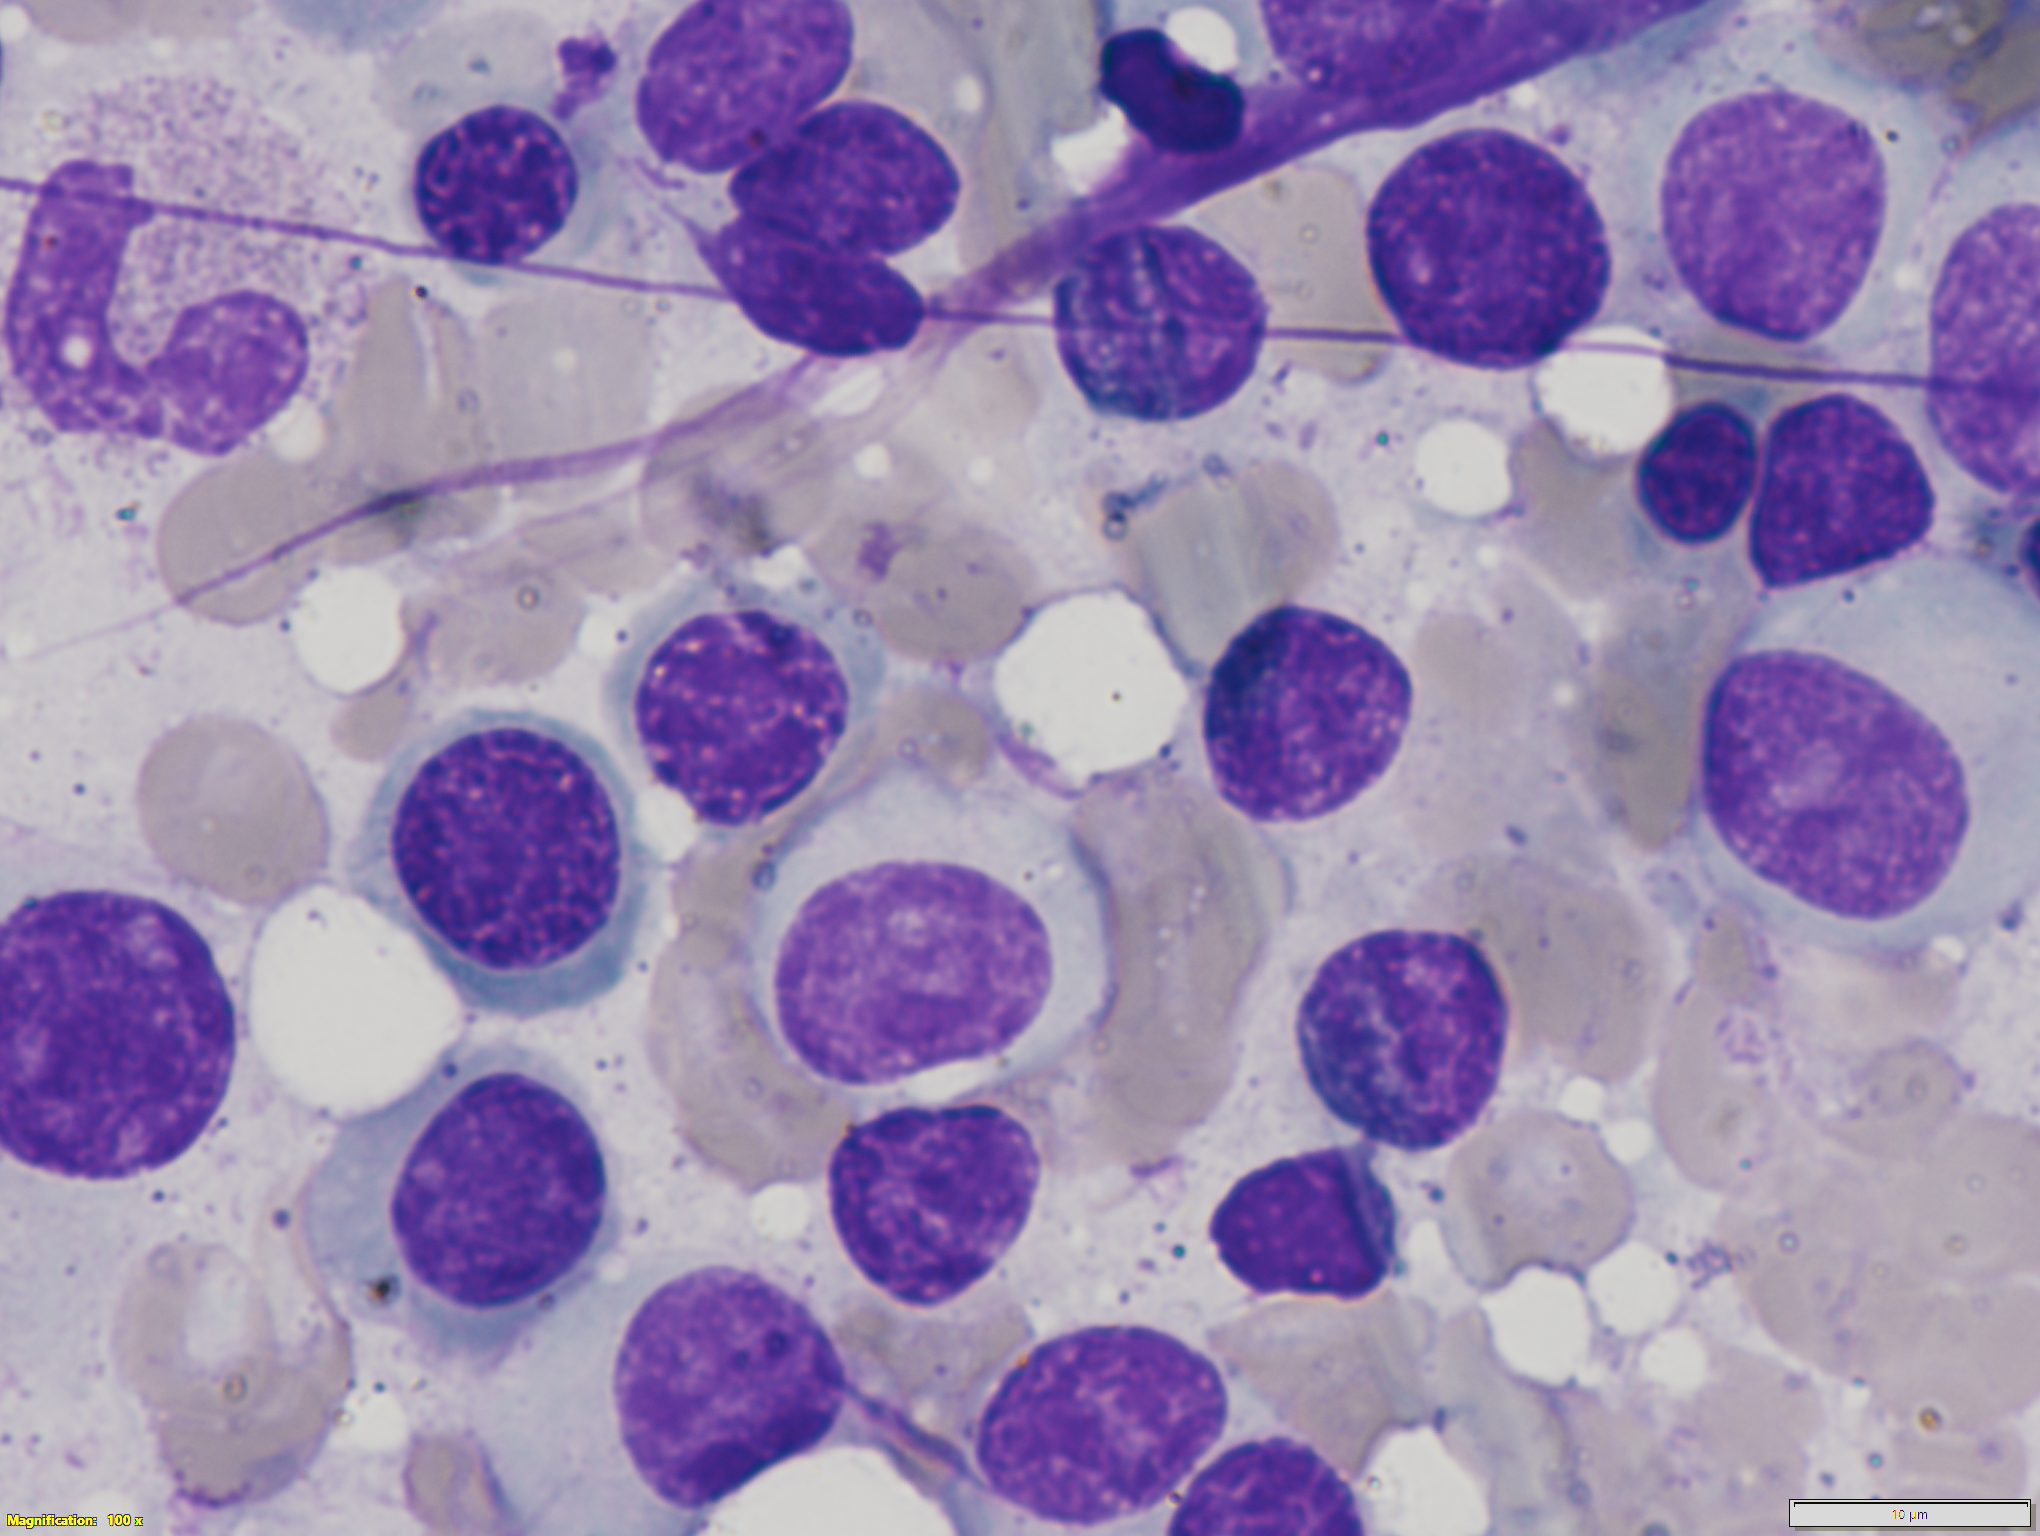

In [18]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

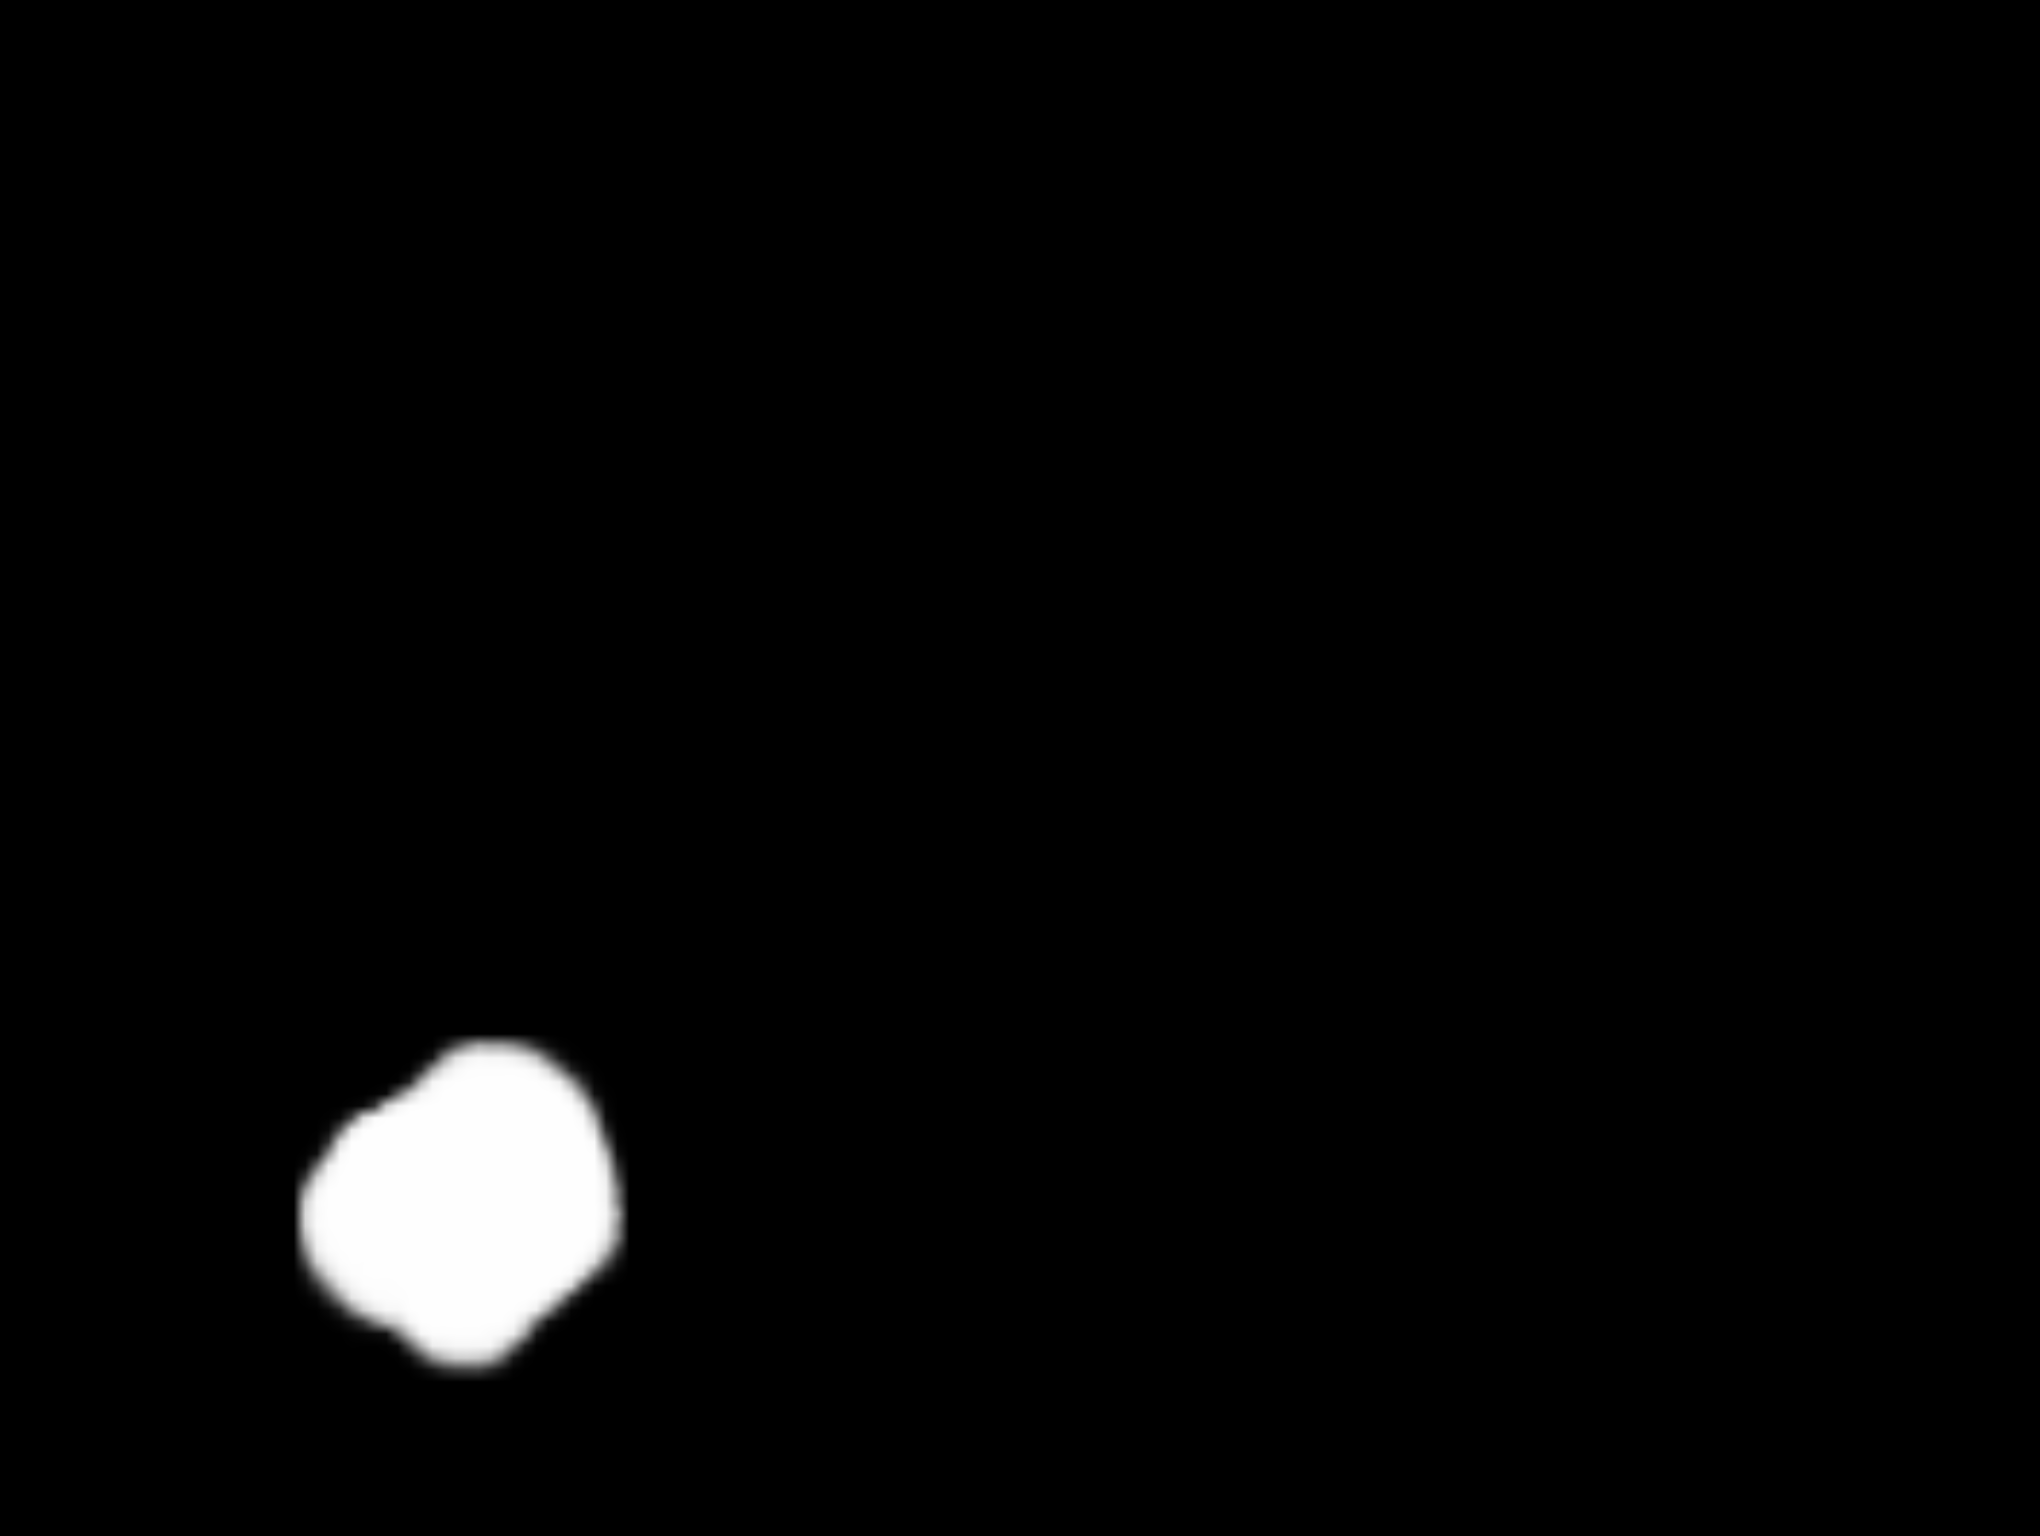

In [20]:
Image.fromarray(prediction[1][0]['masks'][0, 0].mul(255).byte().cpu().numpy())